In [18]:
from collections import defaultdict
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from processing.preprocessing import BCIDataProcessor
import mne


class CCAClassifier:
    def __init__(self, sampling_rate=250, frequencies=(8, 11, 15), num_targets=3, n_components=1, harmonics=1):
        self.frequencies = frequencies
        self.sampling_rate = sampling_rate
        self.num_targets = num_targets
        self.n_components = n_components
        self.harmonics = harmonics

    def get_reference_signals(self, length, target_freq):
        """Generate sine and cosine templates (1st & 2nd harmonics) for a given frequency."""
        t = np.arange(0, length / self.sampling_rate, 1.0 / self.sampling_rate)
        # Create first harmonic reference signals
        ref = [
            np.sin(2 * np.pi * target_freq * t),
            np.cos(2 * np.pi * target_freq * t),
        ]
        # Create additional reference signals based on self.harmonics
        for harmonic in range(2, self.harmonics + 1):
            ref.append(np.sin(2 * np.pi * target_freq * harmonic * t))
            ref.append(np.cos(2 * np.pi * target_freq * harmonic * t))
        ref = np.array(ref)
        return ref

    def find_corr(self, eeg_data, references, n_components=1):
        """Perform CCA between EEG and reference signals for each frequency."""
        cca = CCA(n_components=n_components)
        result = np.zeros(references.shape[0])

        for i in range(references.shape[0]):
            cca.fit(eeg_data.T, references[i].T)
            X_c, Y_c = cca.transform(eeg_data.T, references[i].T)
            corr = [np.corrcoef(X_c[:, j], Y_c[:, j])[0, 1] for j in range(n_components)]
            result[i] = np.max(corr)

        return result

    def fit(self, X):
        # Fit is the same as predict in this case
        self.predict(X)

    def predict(self, X):
        """Classify the EEG signals using CCA."""
        predictions = []
        for eeg_data in X:
            length = eeg_data.shape[1]
            references = np.array([
                self.get_reference_signals(length, freq)
                for freq in self.frequencies
            ])
            correlations = self.find_corr(eeg_data, references, self.n_components)
            predicted_class = self.frequencies[np.argmax(correlations)]
            predicted_class = f'{predicted_class:.1f}'
            predictions.append(predicted_class)
        return np.array(predictions)

In [19]:
recording_path_1 = '../../recordings/recording_ssvep1.raw.fif'
recording_path_2 = '../../recordings/recording_ssvep2.raw.fif'
recording_path_3 = '../../recordings/recording_ssvep4_gel.raw.fif'
rescale = True
window_size = 2
window_overlap = 0
filter_method = 'fir'
l_freq, h_freq = 7, 31

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process(channels=(5, 6, 7))
# Only select 8.0 and 11.0
# data = {label: data[label] for label in data.keys() if label in ['8.0', '11.0']}
data

{'11.0': array([[[ 4.55364912e-17, -1.78077325e-05, -2.80270970e-05, ...,
           2.07858086e-05,  2.48898543e-05,  2.49472578e-05],
         [ 1.78893358e-17, -1.04976287e-05, -1.62434584e-05, ...,
           1.44068391e-05,  1.43863423e-05,  1.27458792e-05],
         [ 1.41488384e-17, -6.66750906e-06, -9.80204844e-06, ...,
           1.07383268e-05,  9.54233259e-06,  7.87335296e-06]],
 
        [[ 2.23789653e-05,  1.98652394e-05,  1.94780248e-05, ...,
           2.47196991e-05,  3.19077576e-05,  2.18357091e-05],
         [ 1.10144133e-05,  1.04683348e-05,  1.13306934e-05, ...,
          -3.65067805e-06,  4.10046345e-07,  1.32170134e-06],
         [ 6.94869691e-06,  7.27807655e-06,  8.42193175e-06, ...,
          -9.71776496e-06, -8.02296044e-06, -4.57447987e-06]],
 
        [[ 1.44469939e-17,  2.89254087e-05,  4.84849992e-05, ...,
          -5.63870116e-07,  5.30944891e-06,  1.03296453e-05],
         [ 1.25225351e-17,  7.78193117e-06,  1.35488046e-05, ...,
           5.04978781e-0

In [20]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X.shape, y.shape

((90, 3, 500), (90,))

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score

classifier = CCAClassifier(sampling_rate=250, frequencies=[11, 8, 15], num_targets=3, n_components=1)
y_pred = classifier.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Classification Accuracy: {acc * 100:.2f}%")

Classification Accuracy: 51.11%


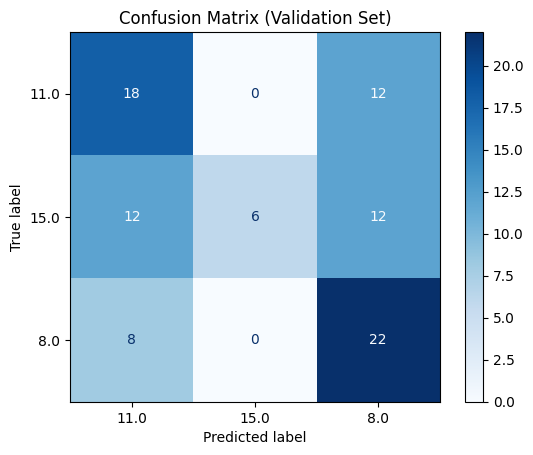

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()